# Autoencoder Trained on MNIST

A PyTorch flavor of the code at From https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726/ and
https://gist.github.com/wmlba/ed6448da9dce3a3c0f6ee78e972dd07b#file-autoencoder_feedforward-py.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DL4DS/sp2025_homeworks/blob/main/lecture_collateral/vae/01_autoencoder_mnist.ipynb)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os


In [2]:
# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

In [3]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ELU(),
            nn.Linear(512, 128),
            nn.ELU(),
            nn.Linear(128, 10),  # bottleneck
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ELU(),
            nn.Linear(128, 512),
            nn.ELU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


In [4]:

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Using device: mps
Training dataset size: 60000
Test dataset size: 10000


In [5]:

# Training loop
def train(model, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        print(f'Epoch: {epoch+1}, Average Loss: {train_loss / len(train_loader):.4f}')


In [6]:
# Get encoded representations and reconstructions
def get_representations(loader, model):
    model.eval()
    encoded_data = []
    decoded_data = []
    original_data = []
    with torch.no_grad():
        for data, _ in loader:
            data = data.view(data.size(0), -1).to(device)
            encoded = model.encode(data)
            decoded = model.decode(encoded)
            encoded_data.append(encoded)
            decoded_data.append(decoded)
            original_data.append(data)
    return torch.cat(encoded_data), torch.cat(decoded_data), torch.cat(original_data)


In [7]:
def visualize_results(original, reconstructed, n=10):
    try:
        # If we're given single images, convert them to batch format
        if len(original.shape) == 1:
            original = original.unsqueeze(0)
        if len(reconstructed.shape) == 1:
            reconstructed = reconstructed.unsqueeze(0)
        
        # Randomly select n indices if we have more than n samples
        if original.shape[0] > n:
            indices = random.sample(range(original.shape[0]), n)
        else:
            indices = range(original.shape[0])
            n = len(indices)
        
        plt.figure(figsize=(20, 4))
        for i, idx in enumerate(indices):
            # Original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(original[idx].detach().cpu().reshape(28, 28).numpy())
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # Reconstructed
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed[idx].detach().cpu().reshape(28, 28).numpy())
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        print(f"Original shape: {original.shape}")
        print(f"Reconstructed shape: {reconstructed.shape}")

In [8]:

# Initialize model, loss function and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())


In [9]:
# Train the model
print("Training the model...")
train(model, optimizer, criterion, epochs=10)
print("Training completed!")

Training the model...
Epoch: 1, Average Loss: 0.0801
Epoch: 2, Average Loss: 0.0511
Epoch: 3, Average Loss: 0.0358
Epoch: 4, Average Loss: 0.0300
Epoch: 5, Average Loss: 0.0273
Epoch: 6, Average Loss: 0.0249
Epoch: 7, Average Loss: 0.0228
Epoch: 8, Average Loss: 0.0212
Epoch: 9, Average Loss: 0.0200
Epoch: 10, Average Loss: 0.0191
Training completed!


In [10]:
# Get encoded and decoded data
print("Getting representations...")
encoded_data, decoded_output, original_data = get_representations(train_loader, model)
print(f"Encoded data shape: {encoded_data.shape}")
print(f"Decoded output shape: {decoded_output.shape}")
print(f"Original data shape: {original_data.shape}")

Getting representations...
Encoded data shape: torch.Size([60000, 10])
Decoded output shape: torch.Size([60000, 784])
Original data shape: torch.Size([60000, 784])


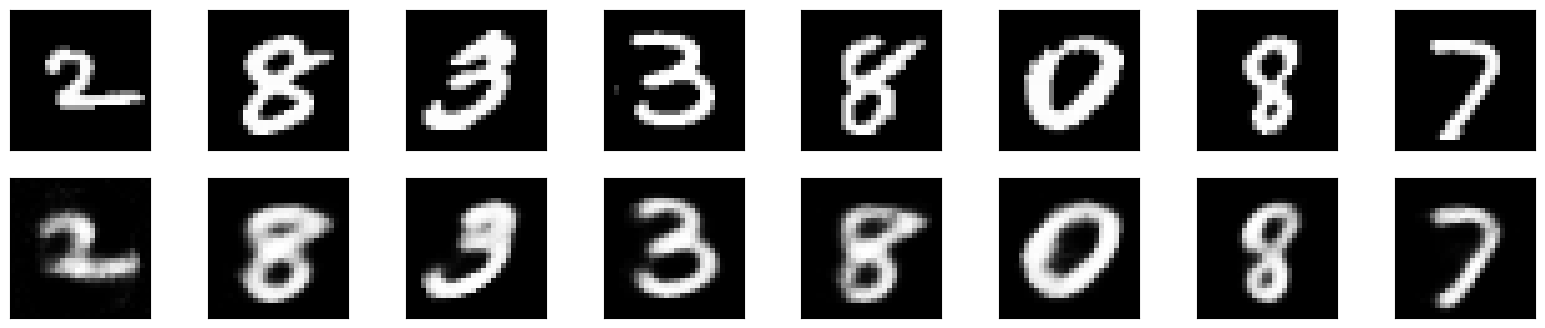

In [11]:
# Example usage for multiple images
indices = random.sample(range(len(train_dataset)), 10)
original_imgs = torch.stack([train_dataset[idx][0].view(-1) for idx in indices])
decoded_imgs = model(original_imgs.to(device)).cpu()

# Visualize multiple image comparisons
visualize_results(original_imgs, decoded_imgs, n=8)